# Config

In [5]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import os
import xmltodict
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

import spacy

DATA_DIR = "./data"
TRAINING_DATA = os.path.join(DATA_DIR, "Laptops_Train_v2.xml")
TESTING_DATA = os.path.join(DATA_DIR, "Laptops_Test_Gold.xml")

In [2]:
nlp = spacy.load('en_core_web_lg')

import regex as re
from spacy.tokenizer import Tokenizer

# this regex is taken from NLTK's WordPunctTokenizer
infix_re = re.compile(r'\w+|[^\w\s]+')

def custom_tokenizer(nlp):
    return Tokenizer(nlp.vocab, infix_finditer=infix_re.finditer)

nlp.tokenizer = custom_tokenizer(nlp)

# Load training data

In [3]:
from lib.loader import *

In [4]:
training_df = load_data(TRAINING_DATA, nlp)

In [3]:
with open(TRAINING_DATA) as f:
    training_dict = xmltodict.parse(f.read(), strip_whitespace=False)

In [4]:
def get_bio(tokens, aspect_term_info, verbose=False):
    if len(aspect_term_info) == 0:
        aspect_term_info = [(float("inf"), -1, "None")]
    aspect_term_info = sorted(aspect_term_info)
    labels = []
    aspect_from, aspect_to, aspect_term = aspect_term_info.pop(0)
    
    for t in tokens:
        t_from = t.idx
        t_to = t_from + len(t.text)
        
        if t_from == aspect_from:
            curr_label = "B"
        elif t_from > aspect_from and t_to <= aspect_to:
            curr_label = "I"
        else:
            curr_label = "O"
        labels.append(curr_label)
        
        if verbose:
            print("{}\t{}\t{}\t{}\t{}\t{}\t{}".format(t_from, t_to, aspect_from, aspect_to, t.text, curr_label, aspect_term))
        
        # complete the current aspect term, loading the next one
        if t_to >= aspect_to:
            if len(aspect_term_info) == 0:
                aspect_from, aspect_to, aspect_term = (float("inf"), -1, "None")
            else:
                aspect_from, aspect_to, aspect_term = aspect_term_info.pop(0)
    if len(aspect_term_info) != 0:
        raise ValueError("Missing some aspect terms \n\t{} \n\n\t{} \n\n\t".format(aspect_term_info, tokens, labels))
    return labels

In [5]:
training_raw_df = {
    "id": [],
    "text": [],
    "all_aspects": [],
    "token": [],
    "label": []
}

for sentence in training_dict["sentences"]["sentence"]:
    sentence_id = sentence["@id"]
    sentence_text = sentence["text"]
    
    aspect_info = []
    all_terms = sentence.get("aspectTerms", {}).get("aspectTerm", [])
    if type(all_terms) is not list:
        all_terms = [all_terms]
    for aspect_term in all_terms:
        term = aspect_term["@term"]
        idx_from = int(aspect_term["@from"])
        idx_to = int(aspect_term["@to"])
        aspect_info.append((idx_from, idx_to, term))
    
    sentence_tokens = list(nlp(sentence_text))
    labels = get_bio(sentence_tokens, aspect_info)
    
    for n, t in enumerate(sentence_tokens):
        training_raw_df["id"].append(sentence_id)
        training_raw_df["text"].append(sentence_text)
        training_raw_df["all_aspects"].append([a[-1] for a in aspect_info])
        training_raw_df["token"].append(t)
        training_raw_df["label"].append(labels[n])

In [6]:
training_df = pd.DataFrame(training_raw_df)[["id", "token", "label", "all_aspects", "text"]]
training_df["bin_label"] = training_df.label.apply(lambda l: "O" if l == "O" else "I")
training_df["token_num"] = training_df.token.apply(lambda t: len(t.doc))
training_df["loc"] = training_df.token.apply(lambda t: t.i)
training_df["relative_loc"] = (training_df["loc"]) / training_df["token_num"]
training_df["len"] = training_df.token.apply(lambda t: len(t.text))
training_df["pos"] = training_df.token.apply(lambda t: t.pos_)
training_df["detailed_pos"] = training_df.token.apply(lambda t: t.tag_)
training_df["lemma"] = training_df.token.apply(lambda t: t.lemma_)
training_df["dep"] = training_df.token.apply(lambda t: t.dep_)
training_df["cluster"] = training_df.token.apply(lambda t: t.cluster)
training_df["like_num"] = training_df.token.apply(lambda t: t.like_num)
training_df["is_quote"] = training_df.token.apply(lambda t: t.is_quote)
training_df["is_head"] = training_df.token.apply(lambda t: t.head.text == t.text)
training_df["is_alpha"] = training_df.token.apply(lambda t: t.is_alpha)
training_df["is_digit"] = training_df.token.apply(lambda t: t.is_digit)
training_df["is_contain_upper"] = training_df.token.apply(lambda t: len([c for c in t.text if c.isupper()])!=0)
training_df["is_punct"] = training_df.token.apply(lambda t: t.is_punct)
training_df["is_start"] = training_df.token.apply(lambda t: t.i==0)

In [7]:
training_df.head(100)

,id,token,label,all_aspects,text
0,2339,I,O,"[cord, battery life]",I charge it at night and skip taking the cord ...
1,2339,charge,O,"[cord, battery life]",I charge it at night and skip taking the cord ...
2,2339,it,O,"[cord, battery life]",I charge it at night and skip taking the cord ...
3,2339,at,O,"[cord, battery life]",I charge it at night and skip taking the cord ...
4,2339,night,O,"[cord, battery life]",I charge it at night and skip taking the cord ...
5,2339,and,O,"[cord, battery life]",I charge it at night and skip taking the cord ...
6,2339,skip,O,"[cord, battery life]",I charge it at night and skip taking the cord ...
7,2339,taking,O,"[cord, battery life]",I charge it at night and skip taking the cord ...
8,2339,the,O,"[cord, battery life]",I charge it at night and skip taking the cord ...
9,2339,cord,B,"[cord, battery life]",I charge it at night and skip taking the cord ...


In [7]:
training_df.head(100)

,id,token,label,all_aspects,text,bin_label,token_num,loc,relative_loc,len,...,dep,cluster,like_num,is_quote,is_head,is_alpha,is_digit,is_contain_upper,is_punct,is_start
0,2339,I,O,"[cord, battery life]",I charge it at night and skip taking the cord ...,O,19,0,0.000000,1,...,nsubj,346,False,False,False,True,False,True,False,True
1,2339,charge,O,"[cord, battery life]",I charge it at night and skip taking the cord ...,O,19,1,0.052632,6,...,ROOT,101,False,False,True,True,False,False,False,False
2,2339,it,O,"[cord, battery life]",I charge it at night and skip taking the cord ...,O,19,2,0.105263,2,...,dobj,474,False,False,False,True,False,False,False,False
3,2339,at,O,"[cord, battery life]",I charge it at night and skip taking the cord ...,O,19,3,0.157895,2,...,prep,124,False,False,False,True,False,False,False,False
4,2339,night,O,"[cord, battery life]",I charge it at night and skip taking the cord ...,O,19,4,0.210526,5,...,pobj,93,False,False,False,True,False,False,False,False
5,2339,and,O,"[cord, battery life]",I charge it at night and skip taking the cord ...,O,19,5,0.263158,3,...,cc,20,False,False,False,True,False,False,False,False
6,2339,skip,O,"[cord, battery life]",I charge it at night and skip taking the cord ...,O,19,6,0.315789,4,...,conj,3850,False,False,False,True,False,False,False,False
7,2339,taking,O,"[cord, battery life]",I charge it at night and skip taking the cord ...,O,19,7,0.368421,6,...,xcomp,31722,False,False,False,True,False,False,False,False
8,2339,the,O,"[cord, battery life]",I charge it at night and skip taking the cord ...,O,19,8,0.421053,3,...,det,11,False,False,False,True,False,False,False,False
9,2339,cord,B,"[cord, battery life]",I charge it at night and skip taking the cord ...,I,19,9,0.473684,4,...,dobj,717,False,False,False,True,False,False,False,False


In [34]:
training_df[training_df.id=="1738"]

,id,token,label,all_aspects,text,bin_label,token_num,loc,relative_loc,len,...,dep,cluster,like_num,is_quote,is_head,is_alpha,is_digit,is_contain_upper,is_punct,is_start
29495,1738,I,O,"[MacOSX, Windows 7, dual-core, quad-core, 22"" ...","I just plug this into my 22"" Monitor and the s...",O,35,0,0.000000,1,...,nsubj,346,False,False,False,True,False,True,False,True
29496,1738,just,O,"[MacOSX, Windows 7, dual-core, quad-core, 22"" ...","I just plug this into my 22"" Monitor and the s...",O,35,1,0.028571,4,...,advmod,31978,False,False,False,True,False,False,False,False
29497,1738,plug,O,"[MacOSX, Windows 7, dual-core, quad-core, 22"" ...","I just plug this into my 22"" Monitor and the s...",O,35,2,0.057143,4,...,ROOT,437,False,False,True,True,False,False,False,False
29498,1738,this,O,"[MacOSX, Windows 7, dual-core, quad-core, 22"" ...","I just plug this into my 22"" Monitor and the s...",O,35,3,0.085714,4,...,dobj,63,False,False,False,True,False,False,False,False
29499,1738,into,O,"[MacOSX, Windows 7, dual-core, quad-core, 22"" ...","I just plug this into my 22"" Monitor and the s...",O,35,4,0.114286,4,...,prep,8188,False,False,False,True,False,False,False,False
29500,1738,my,O,"[MacOSX, Windows 7, dual-core, quad-core, 22"" ...","I just plug this into my 22"" Monitor and the s...",O,35,5,0.142857,2,...,poss,251,False,False,False,True,False,False,False,False
29501,1738,22,B,"[MacOSX, Windows 7, dual-core, quad-core, 22"" ...","I just plug this into my 22"" Monitor and the s...",I,35,6,0.171429,2,...,nummod,690,True,False,False,False,True,False,False,False
29502,1738,"""",I,"[MacOSX, Windows 7, dual-core, quad-core, 22"" ...","I just plug this into my 22"" Monitor and the s...",I,35,7,0.200000,1,...,punct,0,False,True,False,False,False,False,True,False
29503,1738,Monitor,I,"[MacOSX, Windows 7, dual-core, quad-core, 22"" ...","I just plug this into my 22"" Monitor and the s...",I,35,8,0.228571,7,...,pobj,454,False,False,False,True,False,True,False,False
29504,1738,and,O,"[MacOSX, Windows 7, dual-core, quad-core, 22"" ...","I just plug this into my 22"" Monitor and the s...",O,35,9,0.257143,3,...,cc,20,False,False,False,True,False,False,False,False


In [9]:
training_df.dtypes

id                   object
token                object
label                object
all_aspects          object
text                 object
bin_label            object
token_num             int64
loc                   int64
relative_loc        float64
len                   int64
pos                  object
detailed_pos         object
lemma                object
dep                  object
cluster               int64
like_num               bool
is_quote               bool
is_head                bool
is_alpha               bool
is_digit               bool
is_contain_upper       bool
is_punct               bool
is_start               bool
dtype: object

# Analysis

## Keys Number

### Number of training sentences

In [10]:
training_df.id.nunique()

3045

### Number of aspect terms
- Most of training sentences contains no aspect terms.
  - build first step model to detect no-aspect sentences?
- The maximum number of aspect term is 13.

In [11]:
count_aspect_term = lambda labels: len([l for l in labels if l=="B"])
label_count = training_df.groupby("id").agg({"label": count_aspect_term}).reset_index()
label_count.groupby("label").count()

,id
label,
0,1558
1,929
2,354
3,140
4,43
5,10
6,6
7,3
8,1


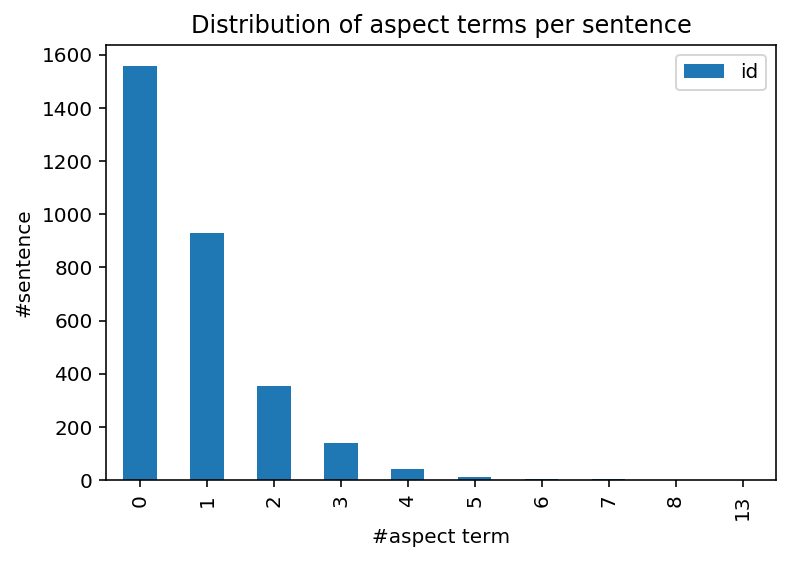

In [12]:
ax = label_count.groupby("label").count().plot.bar()
ax.set_title("Distribution of aspect terms per sentence")
ax.set_ylabel("#sentence")
ax.set_xlabel("#aspect term");

#### What is the sentence containing 13 aspect terms?

In [13]:
id_of_13_labels = label_count[label_count.label==13]["id"].values[0]
target_row = training_df[training_df.id==id_of_13_labels].head(1)[["text", "all_aspects"]]

In [14]:
target_row.iloc[0]["text"]

'There are several programs for school or office use (Pages, Numbers, Keynote, etc.), music (Garageband), photo management (Photo Booth, iPhoto), video-editing or movie-making (iMovie), etc.'

In [15]:
target_row.iloc[0]["all_aspects"]

['programs',
 'Garageband',
 'Photo Booth',
 'iPhoto',
 'iMovie',
 'video-editing',
 'movie-making',
 'photo management',
 'music',
 'Pages',
 'Numbers',
 'Keynote',
 'school or office use']

### Number of tokens in B, I, and O class.
- 92% of tokens are O, and 86% if excluding no-aspect sentence
- This classification problem is a **class-imbalance** task.

In [16]:
training_df.groupby("label").agg({"token": "count"})

,token
label,
B,2357
I,1240
O,48740


In [17]:
2354/48133.*100, (1240+2354)/48133.*100

(4.8906155859805125, 7.4668107119855405)

#### If remove no-aspect sentences

In [18]:
aspect_presence_id = label_count[label_count.label!=0].id
training_df[training_df.id.isin(aspect_presence_id)].groupby("label").agg({"token": "count"})

,token
label,
B,2357
I,1240
O,26147


In [19]:
2354/25860.*100, (1240+2354)/25860.*100

(9.102861562258315, 13.897911832946635)

## Histogram of P( feature | target variable)

In [20]:
is_aspect_mask = training_df.label != "O"
non_aspect_mask = ~is_aspect_mask
features = ["len", "loc", "pos", "detailed_pos", "dep", "cluster", "like_num", "is_quote", "is_head"]

In [21]:
df_raw_ = {
    "@name": [],
    "ucount": [],
    "aspect_ucount": [],
    "non_aspect_ucount": []
}
for f in features:
    df_raw_["@name"].append(f)
    df_raw_["ucount"].append(training_df[f].nunique())
    df_raw_["aspect_ucount"].append(training_df[is_aspect_mask][f].nunique())
    df_raw_["non_aspect_ucount"].append(training_df[non_aspect_mask][f].nunique())
df_out = pd.DataFrame(df_raw_)
df_out[sorted(df_out.columns)]

,@name,aspect_ucount,non_aspect_ucount,ucount
0,len,14,17,17
1,loc,61,85,85
2,pos,15,16,16
3,detailed_pos,29,49,49
4,dep,35,45,45
5,cluster,334,822,837
6,like_num,2,2,2
7,is_quote,2,2,2
8,is_head,2,2,2


[WARNING] Incompatible top value for loc
[WARNING] Incompatible top value for cluster


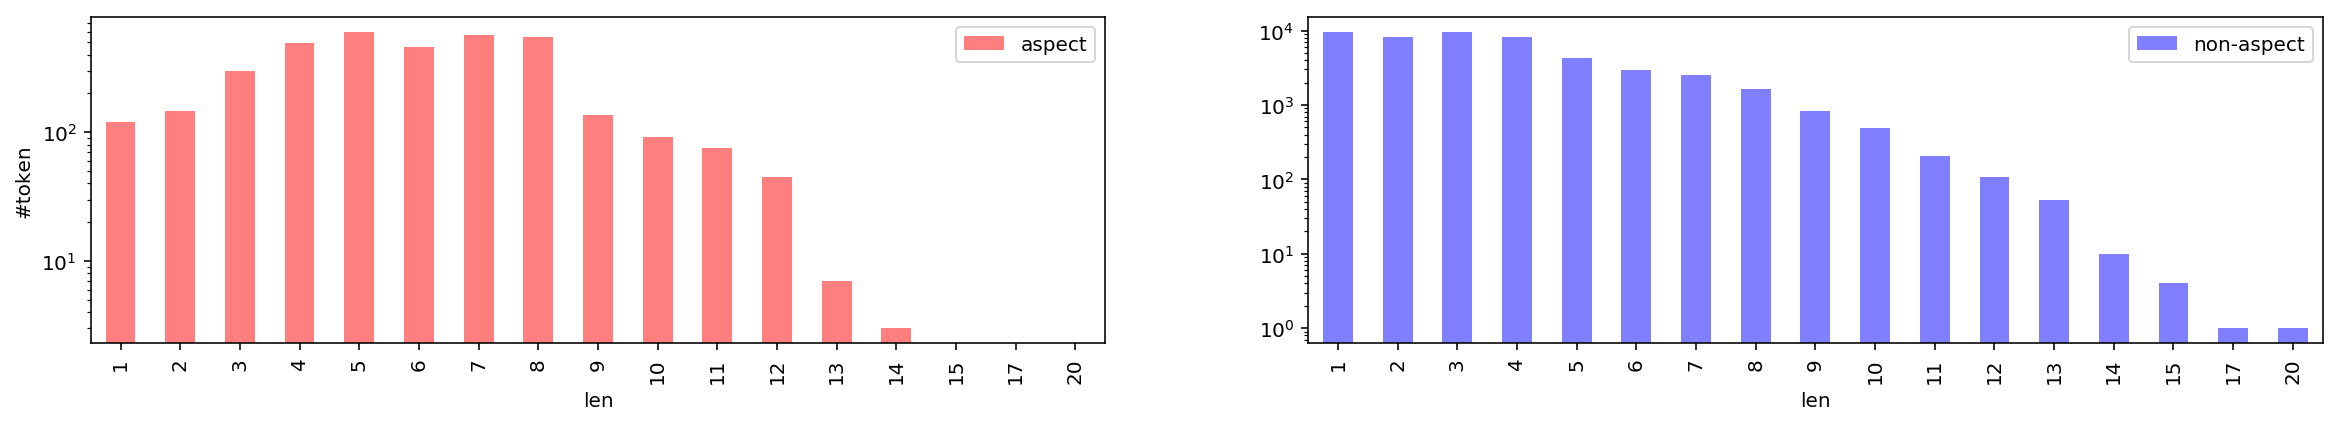

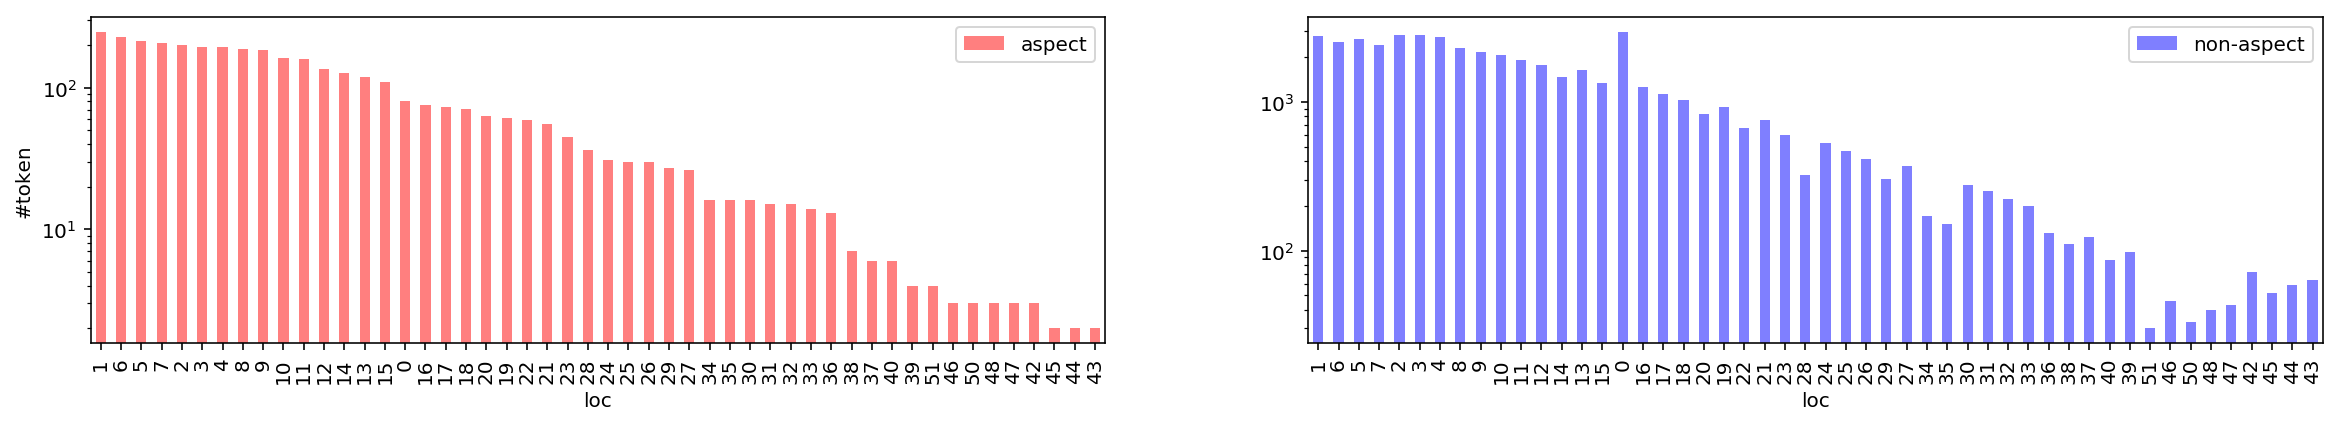

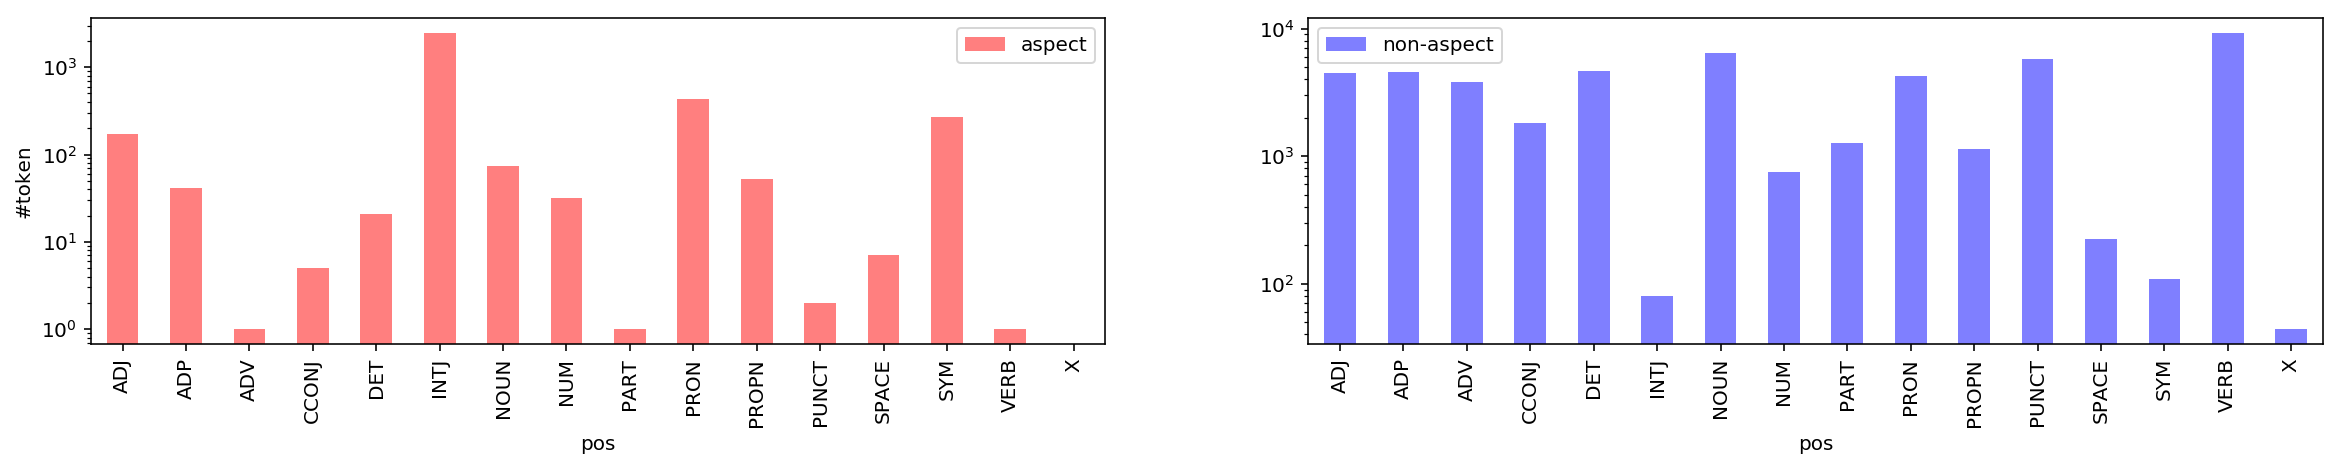

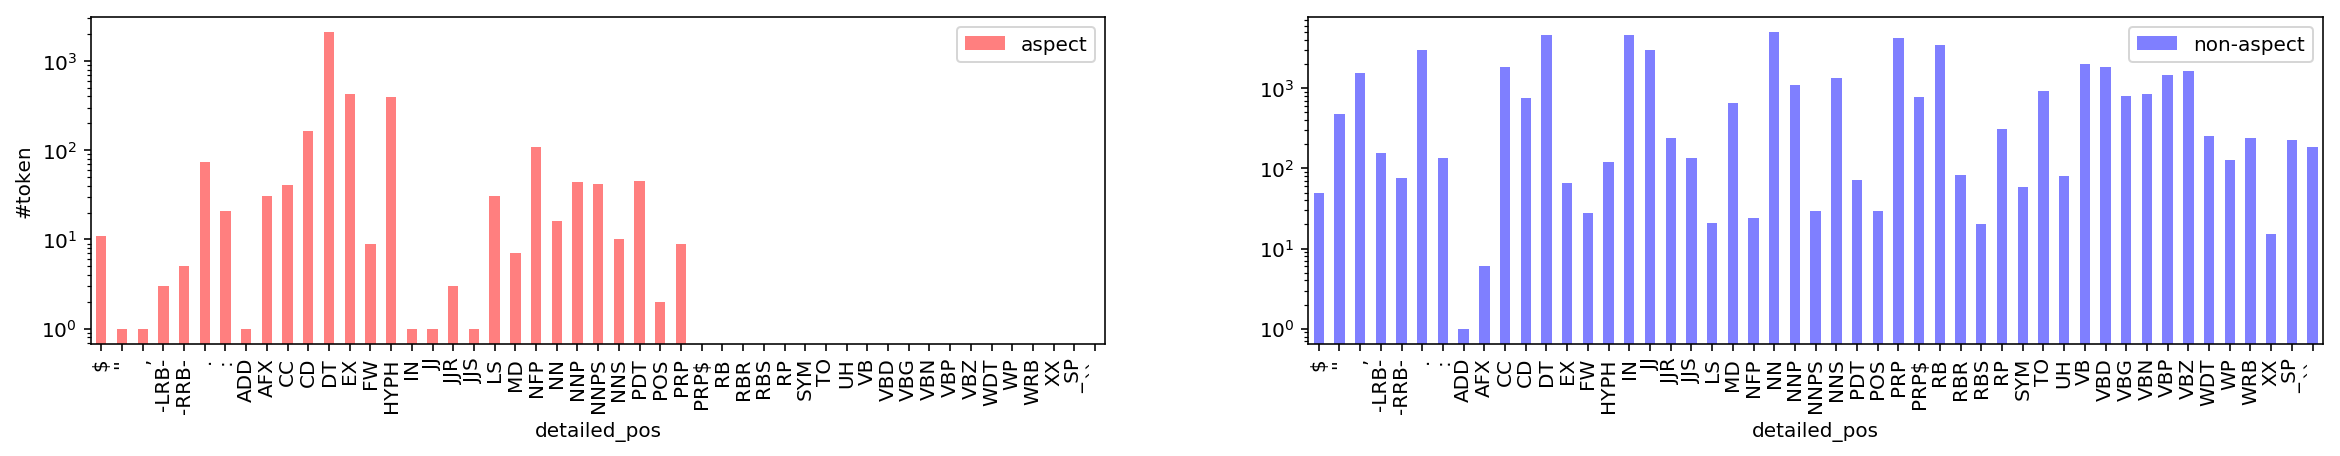

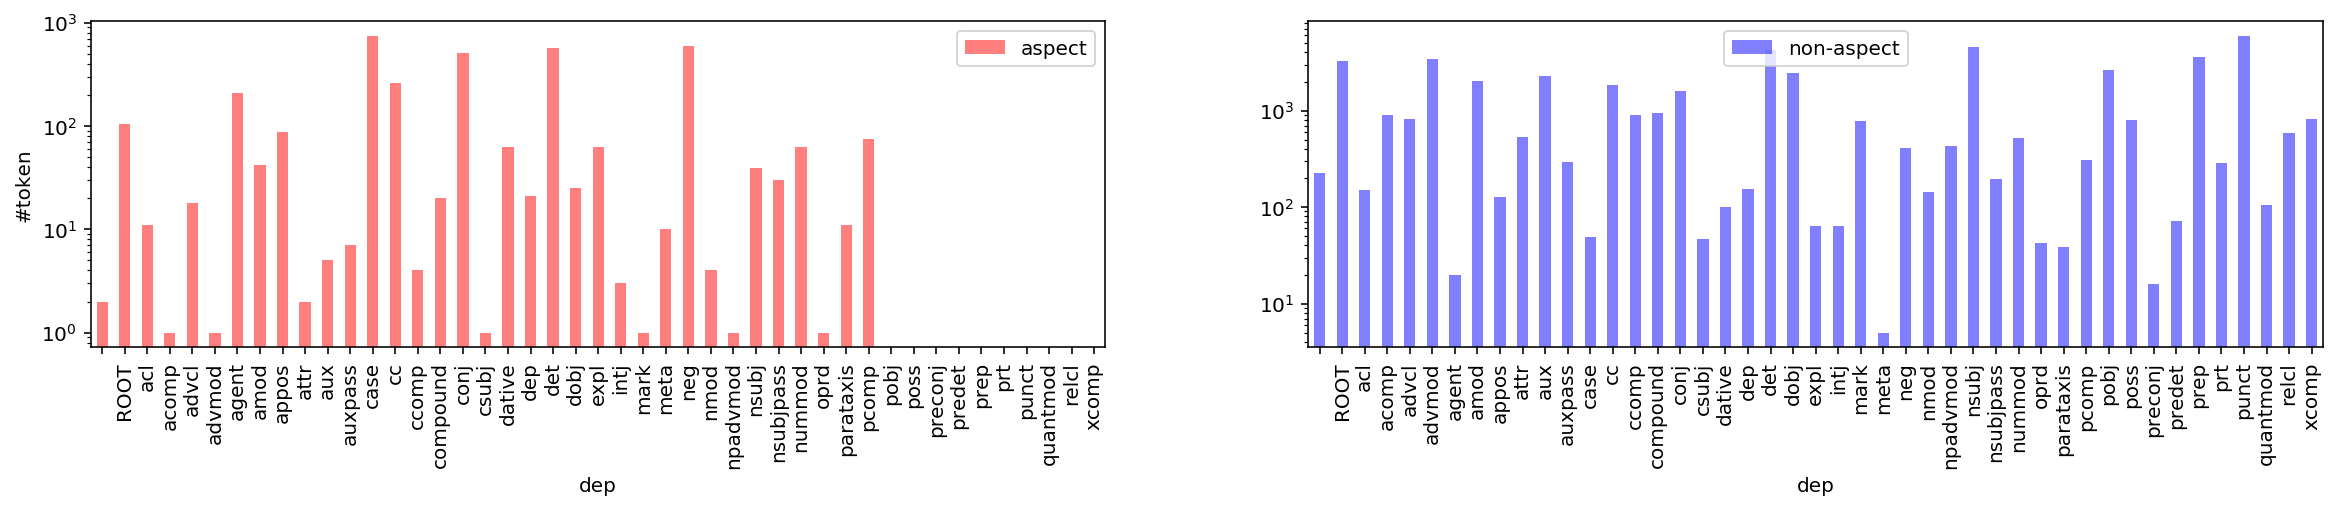

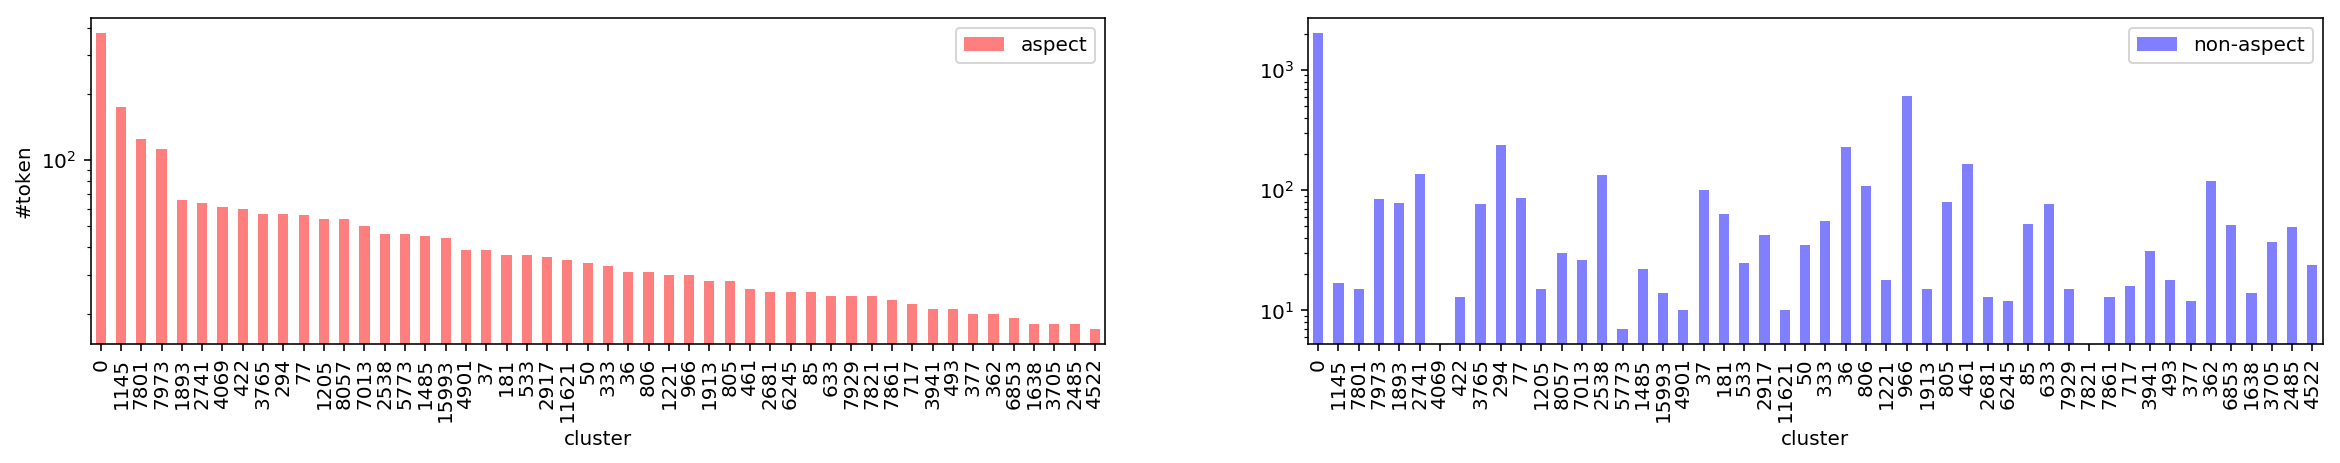

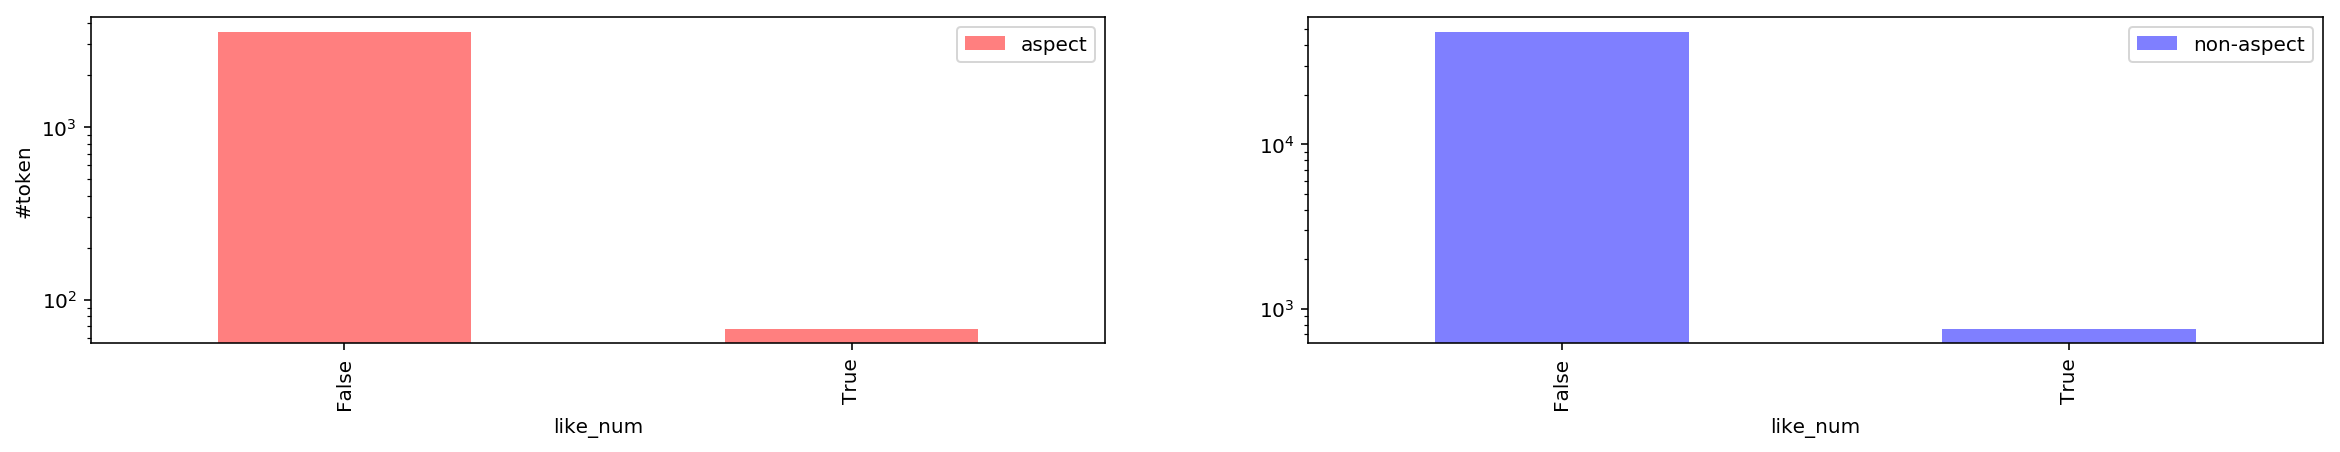

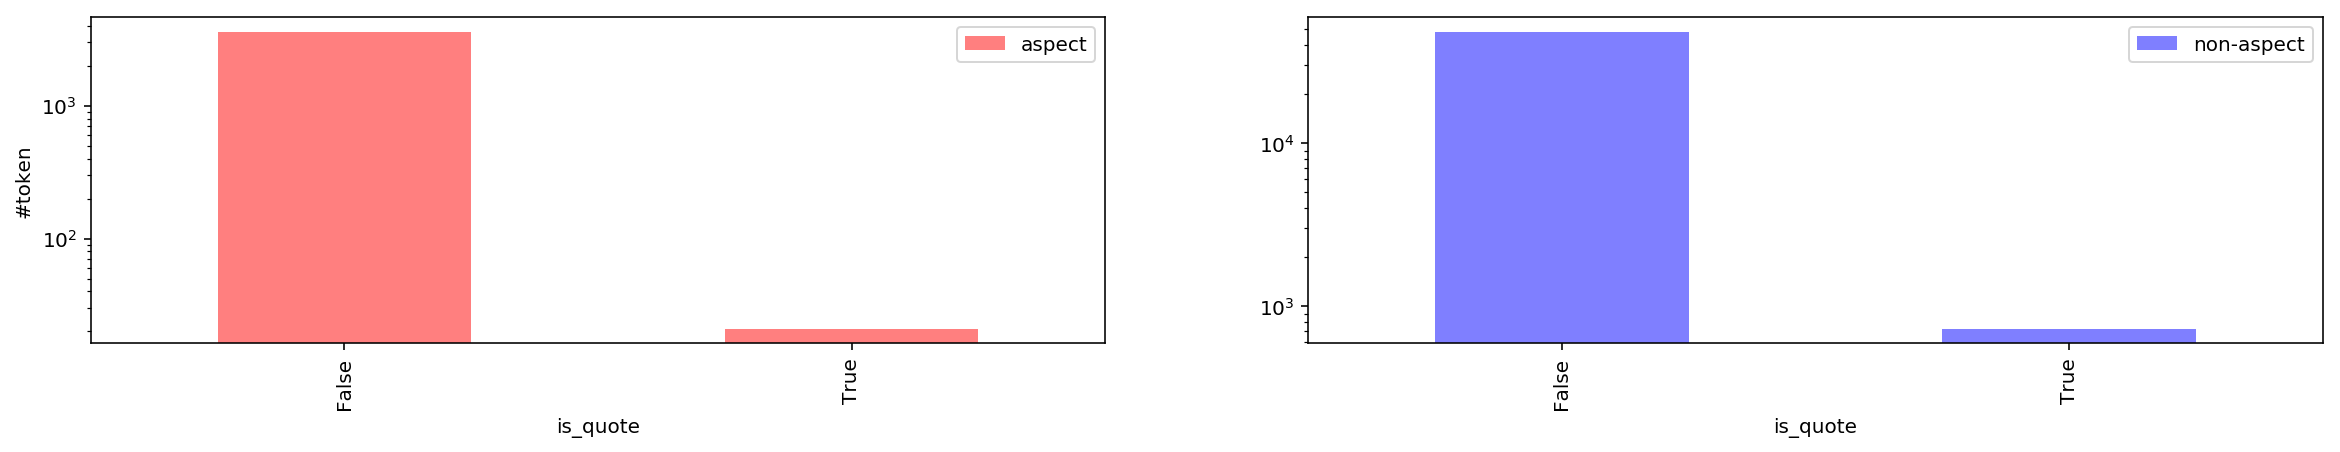

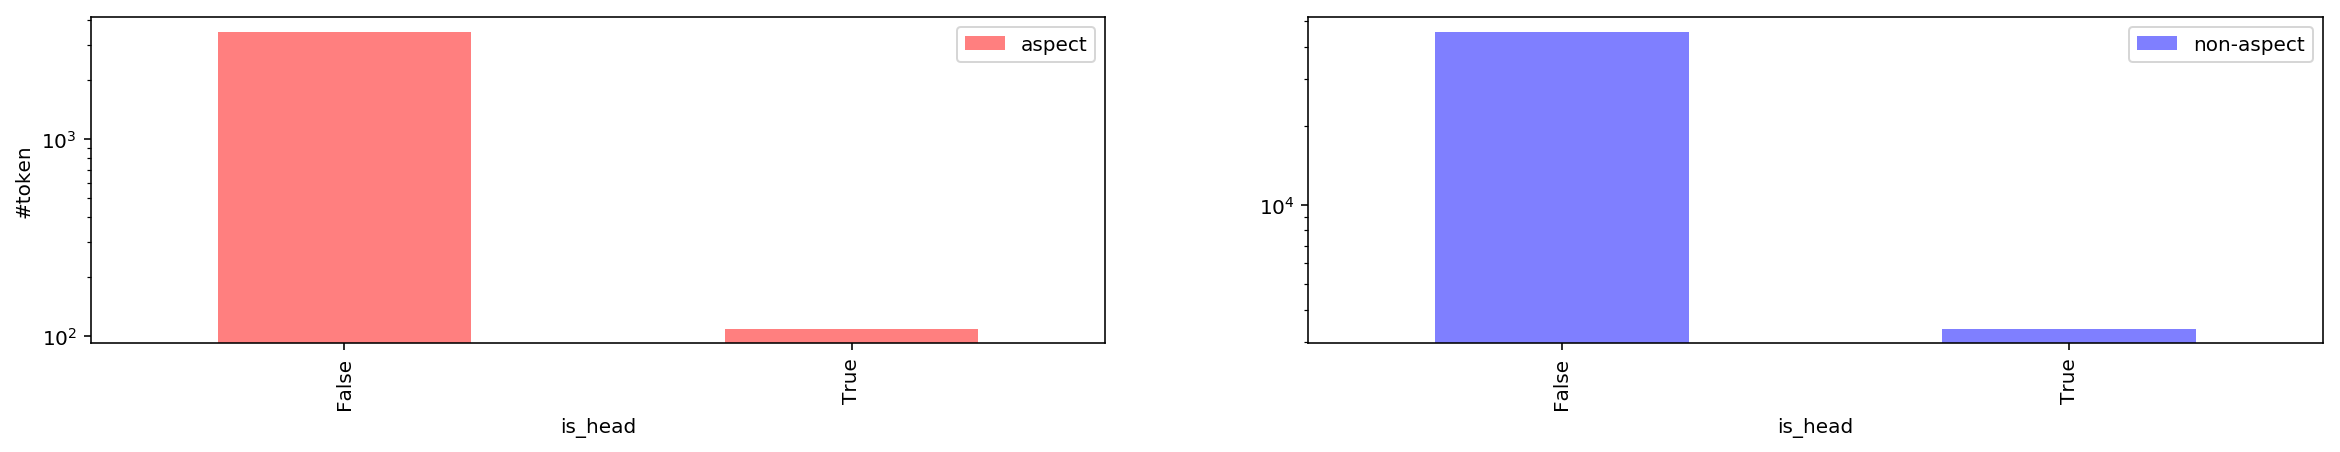

In [22]:
def get_norm_count(aspect_series, non_aspect_series, name, max_var=50):
    out_aspect_df = aspect_series.to_frame().reset_index().groupby(name).count()
    out_non_aspect_df = non_aspect_series.to_frame().reset_index().groupby(name).count()
    if len(out_non_aspect_df) > max_var:
        top_aspect_x = out_aspect_df.sort_values("index", ascending=False).head(max_var).index
        top_non_aspect_x = out_non_aspect_df.sort_values("index", ascending=False).head(max_var).index
        if set(top_aspect_x) != set(top_non_aspect_x):
            print("[WARNING] Incompatible top value for", name)
            key_index = top_aspect_x
        return out_aspect_df.loc[key_index], out_non_aspect_df.loc[key_index]
    return out_aspect_df, out_non_aspect_df

for n, feature in enumerate(features):
    aspect_plot_df, non_aspect_plot_df = get_norm_count(
        training_df[is_aspect_mask][feature],
        training_df[non_aspect_mask][feature],
        feature
    )
    
    f, axes = plt.subplots(1, 2, figsize=(20, 3), sharex=True)
    ax = aspect_plot_df \
        .plot.bar(alpha=0.5, legend=False, color="r", ax=axes[0], logy=True)
    ax.legend(["aspect"])
    ax.set_xlabel(feature)
    ax.set_ylabel("#token")
    ax= non_aspect_plot_df \
        .plot.bar(alpha=0.5, legend=False, color="b", ax=axes[1], logy=True)
    ax.legend(["non-aspect"])
    ax.set_xlabel(feature);

### Investigate loc

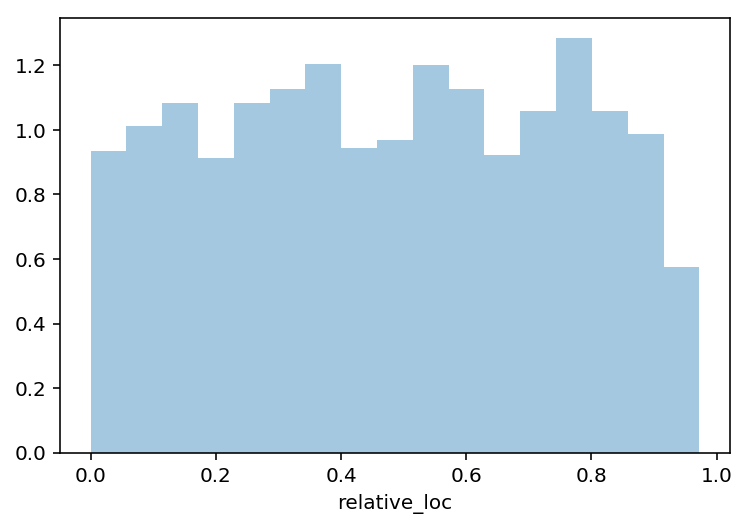

In [23]:
sns.distplot(training_df[is_aspect_mask].relative_loc, norm_hist=True, kde=False)

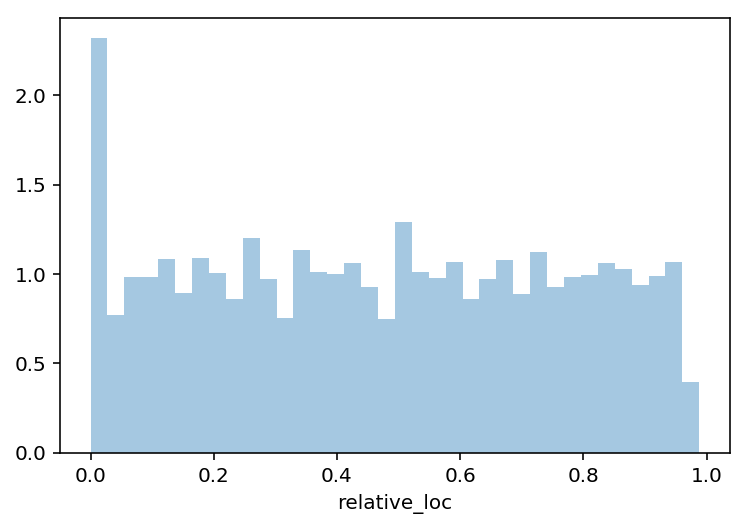

In [24]:
sns.distplot(training_df[non_aspect_mask].relative_loc, norm_hist=True, kde=False)

## Others 

### Can we just do binary classification?
- Yes, no consecutive aspect term in one sentence

In [26]:
def is_consecutive_aspect(labels):
    labels_list = labels.tolist()
    if len(labels) == 0:
        return False
    for n, l in enumerate(labels_list[:-1]):
        if l == "I" and labels_list[n+1] == "B":
            return True
    return False
        

is_consective_df = training_df.groupby("id").agg({"label": is_consecutive_aspect})
is_consective_df.label.value_counts()

False    3045
Name: label, dtype: int64